In [4]:
# FOR CUSP PUI CLASS ON KRIGING
# KRIGING
# BASED ON (with few modifications and improved efficiency demo)
# Connor Johnson
# http://connor-johnson.com/2014/03/20/simple-kriging-in-python/

#warning: some of the syntax will fail on Python 3 because of the use of map

In [5]:
from __future__ import print_function
import numpy as np
import pylab as pl
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import json
import os
s = json.load( open(os.getenv ('PUI2016')+"/fbb_matplotlibrc.json") )
pl.rcParams.update(s)

//anaconda/envs/p2nb/lib/python2.7/site-packages/matplotlib-2.0.0b4+2344.g7b27a1b-py2.7-macosx-10.6-x86_64.egg/matplotlib/__init__.py:910: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/envs/p2nb/lib/python2.7/site-packages/matplotlib-2.0.0b4+2344.g7b27a1b-py2.7-macosx-10.6-x86_64.egg/matplotlib/__init__.py:910: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [6]:
pl.rcParams.update({'axes.facecolor':'#ffffff', 
                    'grid.color': u'#bcbcbc',
                    'xtick.labelsize': 15,
                    'ytick.labelsize': 15})
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
x = np.load("porosoty.npy")
x = x[:,[0,1,3]]
x.shape

(85, 3)

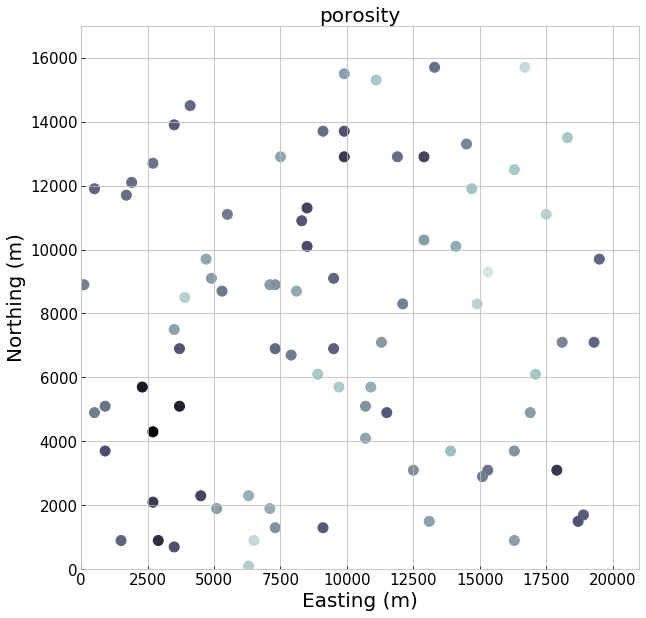

In [8]:
yy = x[:,2]
ax = pl.figure(figsize=(10,10), dpi=150).add_subplot(111)
pl.scatter(x[:,0], x[:,1], c=x[:,2], s=100, cmap='bone')
pl.ylim(0, 17000)
pl.xlim(0, 21000)
pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)
title = pl.title("porosity", fontsize=20)

porosity measures from samples in Zone A at location measured in m 

# the semivariogram is a measure of spatial consistency

$ \hat{\gamma}(h) = \dfrac{1}{2N(h)} \displaystyle \sum_{N(h)} ( z_{i}-z_{j} )^{2} $


In [9]:

squareform?

In [10]:
#print np.array(np.triu_indices(4))>0

In [12]:
def SVh_vctzd( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    This is the vectorized coding-efficient version of the original function SVh() below
    '''
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N
    #print np.triu_indices(N)
    Z = np.zeros((N,N))
    Z = Z - P[:,2]
    #print Z
    Z = Z.T + P[:,2]
    #print Z
    Z = Z**2
    #print Z
    Zcd =  Z[(pdsv >= h - bw) * (pdsv <= h + bw) * \
            (~np.identity(N, dtype=bool))]

    #print Zcd
    return np.sum( Zcd ) / ( 2.0 * len( Zcd ) )

def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    #distance matrix (eucledian)
    pdsv = squareform( pdist( P[:,:2] ) )
    #print (pdsv)
    N = pdsv.shape[0]
    #print (N)

    Z = list()
    for i in range(N):
        for j in range(i+1, N):
            #select only pair of points at the appropriate lag
            if( pdsv[i,j] >= h - bw )and( pdsv[i,j] <= h + bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    #print (Z)
    return np.sum( Z ) / ( 2.0 * len( Z ) )


def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        #print h
        sv.append( SVh( P, h, bw ) )
        #sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T



In [13]:
#test on little data
print (np.array([[0,1,2],[1,2,4],[0,1,3],[3,4,5]]).astype(float))
#print SVh_vctzd( np.array([[0,1,2],[1,2,4],[0,1,3],[3,4,5]]), 1, 0.2 )
print (SVh( np.array([[0,1,2],[1,2,4],[0,2,3],[3,4,5]]).astype(float), 1, 0.2 ))


[[ 0.  1.  2.]
 [ 1.  2.  4.]
 [ 0.  1.  3.]
 [ 3.  4.  5.]]
0.5


In [14]:
mysv = SVh( x, 1000, 500 )
mysv

0.30341364992753639

In [15]:
%timeit -n 1000 mysv = SVh( x, 1000, 500 )


1000 loops, best of 3: 11 ms per loop


In [12]:
print  (SVh_vctzd( x, 1000, 500 ))


0.303413649928


In [16]:
%timeit -n 1000 mysv = SVh_vctzd( x, 1000, 500 )


1000 loops, best of 3: 212 Âµs per loop


In [22]:
mysvd = SVh_vctzd( x, 1000, 500 ))
print  (mysvd)
3.63e-3 / 139e-6, 5.29e-3 / 203e-6

0.303413649928


(26.115107913669068, 26.059113300492612)

Text(0.5,1,u'Sample Semivariogram\nporosity data, lag 100m')

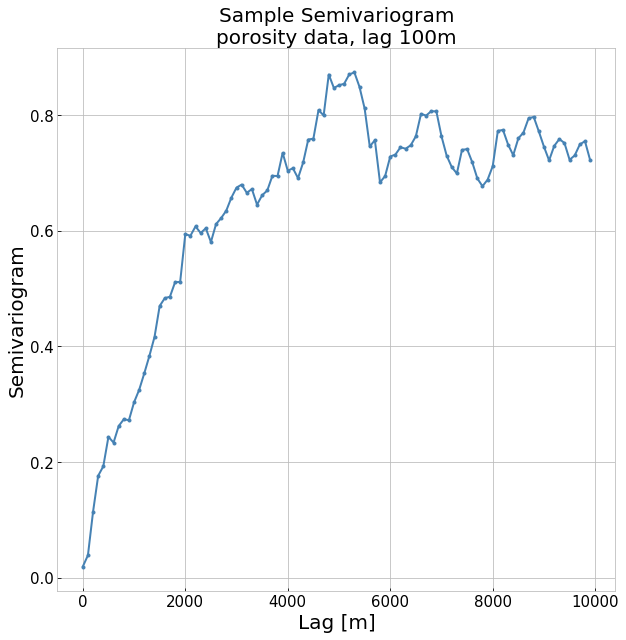

In [24]:

# lags in 500 meter increments from zero to 10,000
hs = np.arange(0, 10500, lag)
#mysv = SV( x, hs, bw )
pl.figure(figsize=(10,10))
plot( mysv[0], mysv[1], '.-' )
pl.xlabel('Lag [m]', fontsize=20)
pl.ylabel('Semivariogram', fontsize=20)
pl.title('Sample Semivariogram\nporosity data, lag %dm'%lag, fontsize=20) 


## Now we need to model the semi-variogram. 
# we can do that with a number of functions: spherica, gaussian, exponential. 

what we do mathematically is solving a MSE problem: it can be shown that the optimal model is one that minimizes

$MSE = Cov(Z_0,Z_0) - 2\lambda_jCov(Z_0,Z_j) + \sum_I \sum_j \lambda_i \lambda_j Cov(Z_i,Z_j)$ 

so we want to find the 

$\lambda's | \frac{d MSE}{d\lambda_k} = 0$

and that is 

$\sum \lambda_j ~Cov(k,j) = Cov(0,k)$

In [25]:
# different variogram models
def opt( fct, x, y, C0, meshSize=1000 ):
    parameterRange = [ x[1], x[-1] ]
    mse = np.zeros( meshSize )
    a = np.linspace( parameterRange[0], parameterRange[1], meshSize )
    for i in range( meshSize ):
        mse[i] = np.mean( ( y - fct( x, a[i], C0 ) )**2.0 )
    return a[ mse.argmin() ]        


def spherical( h, a, C0 ):
    #print "sph"

    '''
    Spherical model of the semivariogram
    '''
    # if h is a single digit

    
    if type(h) == np.float64:
        # calculate the spherical function
        if h <= a:
            return C0*( 1.5*h/a - 0.5*(h/a)**3.0 )
        else:
            return C0
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( spherical, h, a, C0 )

def exponentialngt(h, a, C0):
    #print "exp"
    '''
    Exponential model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-h/a)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( exponentialngt, h, a, C0 )

    
def gaussianngt(h, a, C0):
    #print "gaus"
    '''
    Gaussian model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-(h/a)**2)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( exponentialngt, h, a, C0 )



def C( P, h, bw ):
    '''
    Calculate the sill
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )



def cvmodel( P, model, hs, bw ):
    '''
    Input:  (P)      ndarray, data
            (model)  modeling function
                      - spherical
                      - exponentialngt
                      - gaussian
            (hs)     distances
            (bw)     bandwidth
    Output: (covfct) function modeling the covariance
    '''
    # calculate the semivariogram
    sv = SV( P, hs, bw )
    # calculate the sill
    C0 = C( P, hs[0], bw )
    #print C0
    # calculate the optimal parameters
    param = opt( model, sv[0], sv[1], C0 )
    # return a covariance function
    covfct = lambda h, a = param: C0 - model( h, a, C0 )
    return covfct


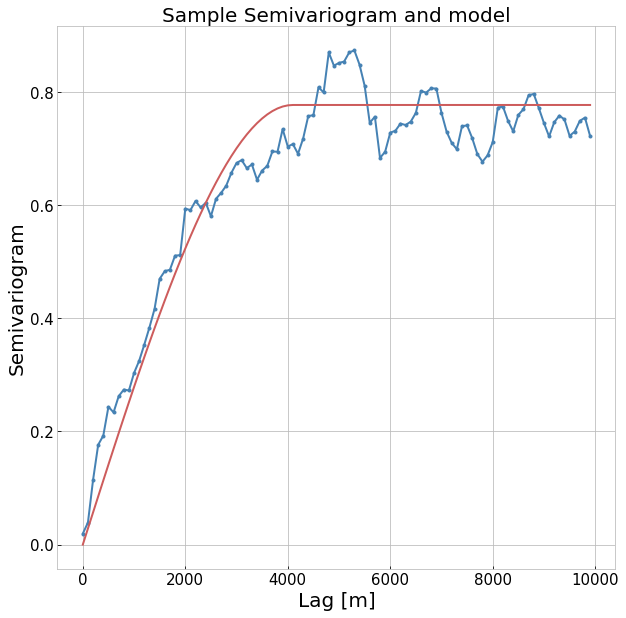

In [26]:
bw = 500
pl.figure(figsize=(10,10))
sp = cvmodel(x, model=spherical, 
             hs=np.arange(0, 10000, 100 ), bw=bw)
#print sp(mysv[0]) 
sphere = sp(mysv[0])
plot( mysv[0], mysv[1], '.-' )
pl.plot(mysv[0], -sphere+sphere.max())
pl.xlabel('Lag [m]', fontsize=20)
pl.ylabel('Semivariogram', fontsize=20)
pl.title('Sample Semivariogram and model', fontsize=20) ;


In [27]:
def krige( P, model, hs, bw, u, N ):
    '''
    Input  (P)     ndarray, data
           (model) modeling function
                    - spherical
                    - exponential
                    - gaussian
           (hs)    kriging distances
           (bw)    kriging bandwidth
           (u)     unsampled point
           (N)     number of neighboring
                   points to consider
    '''
    # covariance function
    covfct = cvmodel( P, model, hs, bw )
    # mean of the variable
    mu = np.mean( P[:,2] )
 
    # distance between u and each data point in P
    d = np.sqrt( ( P[:,0]-u[0] )**2.0 + ( P[:,1]-u[1] )**2.0 )
    # add these distances to P
    P = np.vstack(( P.T, d )).T
    # sort P by these distances
    # take the first N of them
    P = P[d.argsort()[:N]]
 
    # apply the covariance model to the distances
    k = covfct( P[:,3] )
    # cast as a matrix
    k = np.matrix( k ).T
 
    # form a matrix of distances between existing data points
    K = squareform( pdist( P[:,:2] ) )
    # apply the covariance model to these distances
    K = covfct( K.ravel() )
    # re-cast as a NumPy array -- thanks M.L.
    K = np.array( K )
    # reshape into an array
    K = K.reshape(N,N)
    # cast as a matrix
    K = np.matrix( K )
 
    # calculate the kriging weights
    weights = np.linalg.inv( K ) * k
    weights = np.array( weights )
 
    # calculate the residuals
    residuals = P[:,2] - mu
 
    # calculate the estimation
    estimation = np.dot( weights.T, residuals ) + mu
 
    return float( estimation )

In [35]:
#checking how long it takes by just printing out the time stamps
import time

print (time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime())

x0, x1 = x[:,0].min(), x[:,0].max()
y0, y1 = x[:,1].min(), x[:,1].max()
z = np.zeros((8,10))
dx, dy = (x1-x0)/z.shape[1], (y1-y0)/z.shape[0]

for i in range(z.shape[0]):
    print ("\r%d/%d"%(i,z.shape[0]), end="")
    for j in range(z.shape[1]):
        z[i][j] = krige(x, spherical, hs, bw, (dy*j,dx*i), 3)
        
print (time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime())

time.struct_time(tm_year=2016, tm_mon=12, tm_mday=15, tm_hour=17, tm_min=2, tm_sec=35, tm_wday=3, tm_yday=350, tm_isdst=0)
7/8time.struct_time(tm_year=2016, tm_mon=12, tm_mday=15, tm_hour=17, tm_min=4, tm_sec=6, tm_wday=3, tm_yday=350, tm_isdst=0)


([<matplotlib.axis.YTick at 0x10e0aad90>,
 <a list of 3 Text yticklabel objects>)

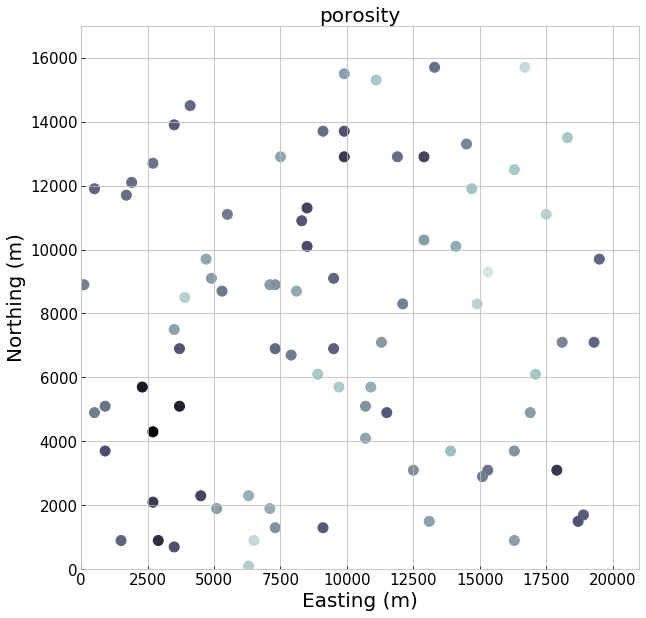

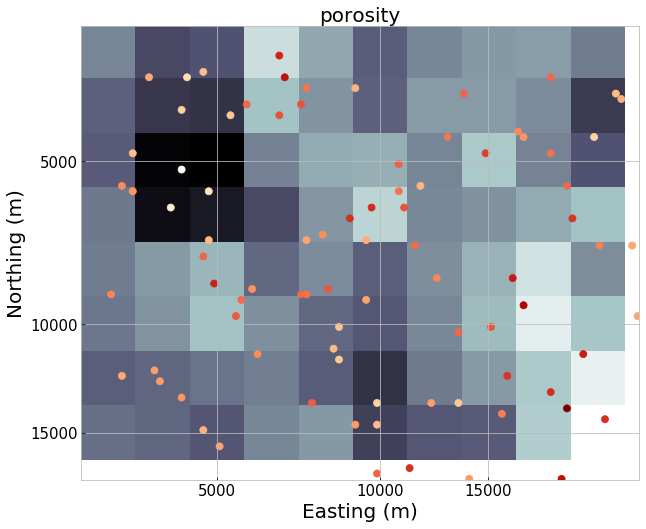

In [36]:
ax = pl.figure(figsize=(10,10), dpi=150).add_subplot(111)
ax.scatter(x[:,0], x[:,1], c=x[:,2], s=100, cmap='bone')
ax.set_ylim(0, 17000)
ax.set_xlim(0, 21000)
ax.set_xlabel("Easting (m)", fontsize=20)
ax.set_ylabel("Northing (m)", fontsize=20)
title = pl.title("porosity", fontsize=20)

ax = pl.figure(figsize=(10,10), dpi=150).add_subplot(111)
H = np.zeros_like(z)
for i in range( z.shape[0] ):
    for j in range( z.shape[1] ):
        H[i,j] = np.round( z[i,j]*3 )
ax.imshow( z, cmap='bone', interpolation='nearest' )
ax.scatter( x[:,0] / 2000.0, x[:,1] / 2000.0, c=x[:,2], cmap='OrRd', 
           linewidths=0.75, s=50 )

#xlim(0,99) ; ylim(0,89)
#ax.axis('off')
ax.set_xlabel("Easting (m)", fontsize=20)
ax.set_ylabel("Northing (m)", fontsize=20)
ax.set_title("porosity", fontsize=20)
xticks( [2,5.0,7], [5000,10000,15000] )
tmp = yticks( [2,5.0,7], [5000,10000,15000] )

In [39]:

print (time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime()))

x0, x1 = x[:,0].min(), x[:,0].max()
y0, y1 = x[:,1].min(), x[:,1].max()
z = np.zeros((40,50))
dx, dy = (x1 - x0) / z.shape[1], (y1 - y0) / z.shape[0]

for i in range(z.shape[0]):
    print ("\r%d/%d"%(i,z.shape[0]), end="")
    for j in range(z.shape[1]):
        z[i][j] = krige(x, spherical, hs, bw, (dy * j, dx * i), 3)
        
print (time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime()))

Thu, 15 Dec 2016 17:05:28 +0000
39/40Thu, 15 Dec 2016 17:49:23 +0000


([<matplotlib.axis.YTick at 0x111a2d510>,
 <a list of 3 Text yticklabel objects>)

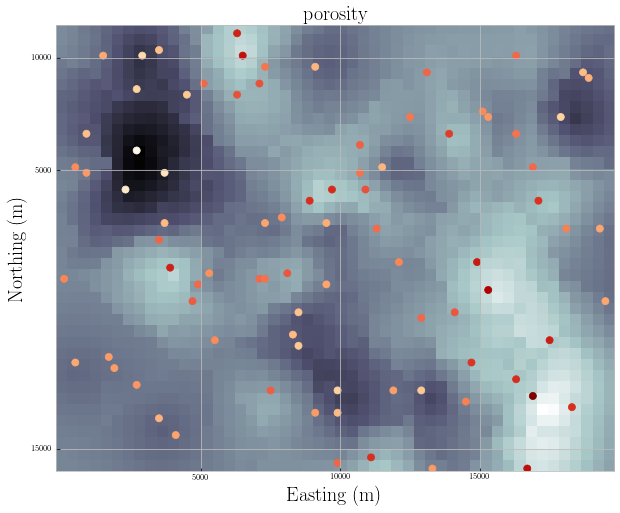

In [47]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)
H = np.zeros_like( z)
for i in range( z.shape[0] ):
    for j in range( z.shape[1] ):
        H[i,j] = np.round( z[i,j]*3 )
        
pl.imshow( z, cmap='bone', interpolation='nearest' )

ax.scatter( x[:,0] / 400.0, x[:,1] / 400.0, c=x[:,2], cmap='OrRd', 
           linewidths=0.75, s=50 )

#xlim(0,99) ; ylim(0,89)
#ax.axis('off')
pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)
pl.title("porosity", fontsize=20)
xticks( [12.5,25.0,37.5], [5000,10000,15000] )
yticks( [12.5,2.50,37.5], [5000,10000,15000] )


In [ ]:
z2=np.zeros_like((z))
H2 = np.zeros_like( z)
for i in range(z2.shape[0]):
    print ("\r%d/%d"%(i,z2.shape[0]), end="")
    for j in range(z2.shape[1]):
        z2[i][j] = krige(x, gaussianngt, hs, bw, (dy*j,dx*i), 3)

([<matplotlib.axis.YTick at 0x111a02e10>,
 <a list of 3 Text yticklabel objects>)

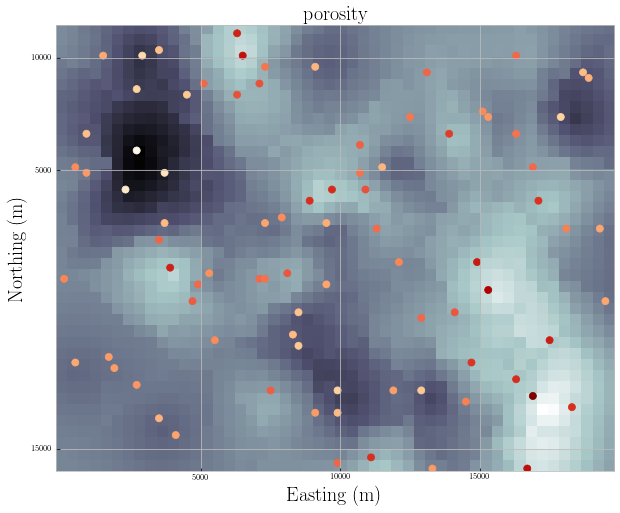

In [49]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)
H = np.zeros_like( z)
for i in range( z.shape[0] ):
    for j in range( z.shape[1] ):
        H[i,j] = np.round( z[i,j]*3 )
        
ax.imshow( z, cmap='bone', interpolation='nearest' , 
          clim=(min(z.flatten()), max(z.flatten())))
ax.scatter( x[:,0]/400.0, x[:,1]/400.0, c=x[:,2], cmap='OrRd',
           linewidths=0.75, s=50 )
#xlim(0,99) ; ylim(0,89)
#ax.axis('off')
pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)
pl.title("porosity", fontsize=20)
xticks( [12.5,25.0,37.5], [5000,10000,15000] )
yticks( [12.5,2.50,37.5], [5000,10000,15000] )


([<matplotlib.axis.YTick at 0x112a3d950>,
 <a list of 3 Text yticklabel objects>)

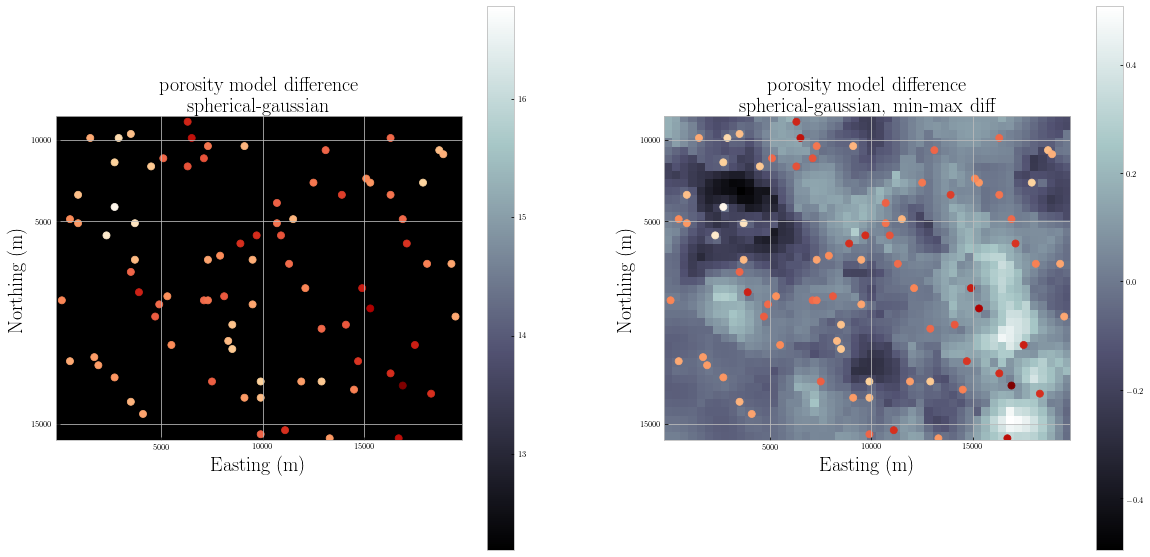

In [50]:
fig = pl.figure(figsize=(20,10))

#the difference between the spherical and gaussian kernel
H = np.zeros_like( z)
for i in range( z.shape[0] ):
    for j in range( z.shape[1] ):
        H[i,j] = np.round( z[i,j]*3 )
ax1 = fig.add_subplot(121)
        
pl.imshow( z - z2, cmap='bone', interpolation='nearest' , 
          clim=(min(z.flatten()), max(z.flatten())))
pl.colorbar()
ax1.scatter( x[:,0]/400.0, x[:,1]/400.0, c=x[:,2], cmap='OrRd',
           linewidths=0.75, s=50 )
#xlim(0,99) ; ylim(0,89)
#ax.axis('off')

pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)
pl.title("porosity model difference\nspherical-gaussian", fontsize=20)
xticks( [12.5,25.0,37.5], [5000,10000,15000] )
yticks( [12.5,2.50,37.5], [5000,10000,15000] )

ax2 = fig.add_subplot(122)
        
pl.imshow( z - z2, cmap='bone', interpolation='nearest' )
pl.colorbar()
ax2.scatter( x[:,0]/400.0, x[:,1]/400.0, c=x[:,2], cmap='OrRd',
           linewidths=0.75, s=50 )
#xlim(0,99) ; ylim(0,89)
#ax.axis('off')

pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)
pl.title("porosity model difference\nspherical-gaussian, min-max diff", fontsize=20)
xticks( [12.5,25.0,37.5], [5000,10000,15000] )
yticks( [12.5,2.50,37.5], [5000,10000,15000] )